# Tutorial: Optimization

# Part 1: Convex and Linear Optimization

## Optimization Basics, Convexity and Classification
### Exercise 1: Optimization Problem Statement

Formally state an optimization problem for a space engineering scenario: Minimize fuel consumption ($f(\mathbf{x}) = \mathbf{c}^\top \mathbf{x}$) for a satellite maneuver, subject to thrust limits ($\mathbf{A} \mathbf{x} \leq \mathbf{b}$) and energy balance ($\mathbf{h}(\mathbf{x}) = 0$). Identify degrees of freedom and classify as LP or NLP. Discuss both model development and complexity with your colleagues.

HINT: You don't have to write out the full model in order to compute the DoF for the physics inside the energy balances and thurst relations, but it might be worth your time to look at those models from the chapters on simulation.

### Exercise 2: Convexity (shapes)

Classify the following shapes as convex or non-convex:


<img src="../images/7_0_shapes.svg"
     alt="A collection of convex and non-convex geometric shapes"
     width="500">
<br>

HINT: Remember the formal definition of convexity: if you pick any points $a, b \in \mathcal{X}$ and draw a line between them then it should not intersect with the boundary of the shape. In this case the domain $\mathcal{X}$ is the interior of the shape.


### Exercise 3: Convexity (functions)

1. Prove that the function $f(x) = x^2$ is convex using the definition. For the nonconvex $f(x) = x^4 - 3x^2$, find points where the line segment intersects the curve.
2. The code below modifies the chapter's ipywidgets code to test new functions, e.g., $f(x) = e^x$ (convex) vs. $f(x) = \sin(x)$ (nonconvex). Propose two new functions -one convex and one non-convex- then test

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider

# Define the functions
def convex_func(x):
    return np.exp(x)

def nonconvex_func(x):
    return np.sin(x)

# Interactive plotting function
def plot_convexity(a=-1.0, b=1.0):
    if a >= b:
        print("Please set a < b.")
        return

    x = np.linspace(-2, 2, 1000)

    # Subset for line segment (between a and b)
    mask = (x >= a) & (x <= b)
    x_segment = x[mask]

    # Convex function
    y_convex = convex_func(x)
    y_line_convex = convex_func(a) + (x_segment - a) * (convex_func(b) - convex_func(a)) / (b - a)

    # Nonconvex function
    y_nonconvex = nonconvex_func(x)
    y_line_nonconvex = nonconvex_func(a) + (x_segment - a) * (nonconvex_func(b) - nonconvex_func(a)) / (b - a)

    # Create subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Convex plot
    axs[0].plot(x, y_convex, label='$f(x) = x^2$ (Convex)', color='blue')
    axs[0].plot(x_segment, y_line_convex, label='Line segment', color='red', linestyle='--')
    axs[0].scatter([a, b], [convex_func(a), convex_func(b)], color='green', zorder=5)
    axs[0].set_title('Convex Function')
    axs[0].set_xlabel('x')
    axs[0].set_ylabel('f(x)')
    axs[0].legend()
    axs[0].grid(True)

    # Nonconvex plot
    axs[1].plot(x, y_nonconvex, label='$f(x) = x^4 - 3x^2$ (Nonconvex)', color='blue')
    axs[1].plot(x_segment, y_line_nonconvex, label='Line segment', color='red', linestyle='--')
    axs[1].scatter([a, b], [nonconvex_func(a), nonconvex_func(b)], color='green', zorder=5)
    axs[1].set_title('Nonconvex Function')
    axs[1].set_xlabel('x')
    axs[1].set_ylabel('f(x)')
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

# Create sliders
a_slider = FloatSlider(min=-2, max=2, step=0.1, value=-1.5, description='a:')
b_slider = FloatSlider(min=-2, max=2, step=0.1, value=1.5, description='b:')

interact(plot_convexity, a=a_slider, b=b_slider);

interactive(children=(FloatSlider(value=-1.5, description='a:', max=2.0, min=-2.0), FloatSlider(value=1.5, des…

### Exercise 4: Problem classification and standard form

Classify the following three problems, then write them in standard form (in other words, write in a form that should be accepted by a solver, but do not solve in code):

1. Minimize the objective function $x_1 + 2 x_2$ subject to the constraint $4 x_1 + 6 x_2 \le 10$ and bounded from below ($x_1, x_2 \ge 0$).
2. Maximize the objective $ - 3^3 x_1 - x_2$ subject to the set of constraints $\mathbf{g(x)} = \left\{ x_1 + x_2 \le 1, x_1 \le 1, -x_2 \le -3 \right\}$.
3. Minmize the objective function $f(\mathbf{x}) = 2 x_1^2 + x_1 x_2 + 2 x_2^2 $ with boundaries $x_1 \in \left[-1.5, 1.5 \right]$ and $x_2 \in \left[-2, 2 \right]$.

## Linear programming (LP)

### Excercise 5: Linear Programming with Simplex, IPM, and HiGHS

In this excercise we will implement and compare LP solvers on a higher-dimensional problem, emphasizing computational efficiency.

Problem Setup: Consider a higher-dimensional LP inspired by space mission resource allocation: Maximize weighted payload value for a spacecraft fleet subject to constraints on fuel, crew hours, volume, and total mass. The derived model is:

$$\begin{align*}
\max \quad & 5x_1 + 4x_2 + 3x_3 + 2x_4 \\
\text{subject to} \quad & 2x_1 + x_2 + 3x_3 + x_4 \leq 10, \\
& x_1 + 2x_2 + x_3 + 3x_4 \leq 12, \\
& 3x_1 + x_2 + 2x_3 + 2x_4 \leq 11, \\
& x_1 + x_2 + x_3 + x_4 \leq 5, \\
& x_1, x_2, x_3, x_4 \geq 0.
\end{align*}
$$

Here, $x_1, x_2, x_3, x_4$ represent masses allocated to four modules with different values (e.g., scientific instruments prioritized higher). This is a 4-variable, 4-constraint LP (higher-dimensional than the 2D example).

1. Practice converting this to standard form by hand, before coding. You can validate your solution by computing $\mathbf{c}^\top \mathbf{x}$ and comparing with the benchmark solutions below (i.e. you should get that $\mathbf{c}^\top \mathbf{x} = 23.00$ for your solution $\mathbf{x}$.


2. Implement the objective and constraints in code. Solve using scipy.optimize.linprog with:

- 'revised simplex',
- 'interior-point',
- 'highs'.

Benchmark each solver using timeit or similar and compare runtimes (run multiple iterations for accuracy). Plot or print optima and discuss differences (if any).

3. Discuss the comparison of solver times, due to differences in your machine build and back-end libraries you might get different results, discuss if the result below are in line with our expectations from the lectures:

```
Method: revised simplex:
- Optimal value: 23.00,
- x: [3. 2. 0. 0.],
- Time: 0.002612 s

Method: interior-point
- Optimal value: 23.00
- x: [3.00000000e+00 2.00000000e+00 2.34280548e-11 4.72679422e-12]
- Time: 0.002060 s

Method: highs
- Optimal value: 23.00,
- x: [3. 2. 0. 0.]
- Time: 0.001106 s
```

A visual comparison of the benchmark times for the three solvers can be found in the bar graph below:

<img src="../images/7_1_LP_results.png"
     alt="Benchmark times for 3 LP solvers"
     width="500">
<br>

## Quadratic programming

### (Optional) Exercise 6: Quadratic Programming and Least-Squares

In this exercise we will implement a basic QP problem

Problem Formulation: Consider a basic QP problem for portfolio optimization: Minimize the risk (quadratic variance) of a two-asset portfolio while achieving a target return, subject to budget constraints. Formally:$$\begin{align*}
\min \quad & x_1^2 + 0.5 x_1 x_2 + x_2^2 - 2x_1 - 3x_2 \\
\text{subject to} \quad & x_1 + x_2 = 1, \\
& x_1, x_2 \geq 0.
\end{align*}$$

Here, $x_1, x_2$ are investment fractions in two assets.

1. Rewrite this in standard QP matrix form (identify $\mathbf{Q}$, $\mathbf{c}$, equality constraints) by hand. Discuss why it's convex (check Hessian).
2. Implement the objective and constraints in Python. Solve using scipy.optimize.minimize with 'SLSQP' (Sequential Least Squares Programming, suitable for constrained QP). Print the optimum and verify against unconstrained solution.

HINT: For validation your solution should be $f^* = -2.04$ at $ x_1 = 0.17$ and $x_2 = 0.83$. You can additionally validate the solution by plotting slices of the objective funciton in the $x_1$ and/or $x_2$ planes.

## Linear least squares

### Exercise 7: Linear Least-Squares (40 minutes)

In this excercise we will solve an overdetermined system via least-squares and visualize noisy data fitting. First we geenerate synthetic noisy data for a quadratic regression model, then we will fit parameters to polynomial $y = a x^2 + b x + c$ from 20 noisy measurements over $x \in [0, 10]$. The code snippet below does for an _underlying_ model $y = 0.1 x^2 + 2 x + 1$ with Gaussian noise added using `np.random.normal` (you can confirm visualy what this noise looks like using e.g. `plt.hist`)

1. Discuss how this connects overdetermined equations ($m=20 > n=3$) to optimization ($\min \| \mathbf{A} \mathbf{x} - \mathbf{y} \|_2^2$).
2. Python Implementation: Create the design matrix $\mathbf{A}$ (columns: $x^2, x, 1$), add Gaussian noise to true $y = 0.1 x^2 + 2 x + 1$, solve with np.linalg.lstsq, and plot data vs. fit. Compute residuals and discuss fit quality.
3. Adjust the noise levels and resolve the problem, comment on the difference between the solutions to the underlying coefficients.

In [45]:
import numpy as np
import matplotlib.pyplot as plt

# Generate noisy data
x = np.linspace(0, 10, 20)
true_y = 0.1 * x**2 + 2 * x + 1
noise = np.random.normal(0, 1, len(x))  # Gaussian noise
y = true_y + noise
y

array([ 1.03114498,  1.42896696,  1.87300985,  4.65066154,  5.74931348,
        8.7488615 ,  8.1319468 , 10.242349  , 10.54702088, 10.60687685,
       13.88227284, 15.78749835, 15.12194035, 17.88486255, 21.62888049,
       23.45397106, 24.87591357, 27.08759528, 28.96289241, 32.51720627])

## Convex optimization

### (Optional) Exercise 8: Local convexity and penalty constraints

The code below is taken from the lecture notes problem to minimize $f(x) = x^2 + \sin(2\pi x)$. It should be noted that of course this function is _not_ globally convex, however, there are local basins of attraction where the problem is locally convex.

1. Define the subdomains $[x_l, x_u] \in [-1.5, 2] \in \mathcal{X}$ where the objective function $f$ is locally convex (either rigorously or just select the domains by hand).


In [165]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider

# Define f and grad_f (missing in your snippet!)
def f(x):
    return x**2 + np.sin(2 * np.pi * x)

def grad_f(x):
    return 2*x + 2*np.pi*np.cos(2*np.pi*x)

def gd_demo(alpha=0.01, x_start=1.5):
    x = x_start
    history = [x]
    for _ in range(100):
        x -= alpha * grad_f(x)
        history.append(x)

    x = np.linspace(-2, 2, 1000)
    plt.figure(figsize=(8, 5))  # Added for clarity
    plt.plot(x, f(x), label='$f(x)$')
    plt.plot(history, f(np.array(history)), 'ro-', label='GD Path')
    plt.xlabel('x')
    plt.ylabel('f(x)')
    plt.title(f'GD with α={alpha}, start={x_start}')
    plt.legend()
    plt.grid(True)
    plt.show()

interact(gd_demo, alpha=FloatSlider(min=0.001, max=0.1, step=0.001, value=0.01),
         x_start=FloatSlider(min=-2, max=2, step=0.1, value=1.5));

interactive(children=(FloatSlider(value=0.01, description='alpha', max=0.1, min=0.001, step=0.001), FloatSlide…

#### Penalty Functions

We already saw with the IPM method how penalty barrier methods can be used to constrain and/or guide the optimization routine towards a desired solution. Such **penalty barrier** methods are useful constructions that allow us to improve our optimizations. For example, suppose that in the above function only care about finding the global minimum around $x^* \approx -0.25$. In order to reliably find the value of the objective  $f^* = f(x^*)$ (for any starting value $x_0$ and/or $\alpha$ value) we can implement penalty barriers in a locally convex domain $x \in [x_l, x_u]$ as follows:

$$ \min f_p (\mathbf x) := f (\mathbf x) + ~ \sum_{i\in I} p_i ~  g(c_i(\mathbf x)) $$

where

$g(c_i(\mathbf x))=\max(0,c_i(\mathbf x ))^2$

In the above equations, $g(c_i(\mathbf x))$  is the penalty function while $p$ is called a penalty coefficient. The coefficients must be tuned so that they are aggressive" enough to ensure convexity without making the final problem too ill-conditioned to solve. These kind of methods have the advantage that faster unconstrained GD methods can be used to solve the problem while the disadvantage is the possibility of breaking the solver by making the constraints too aggressive.

As an example of what these functions look like in 1D see the simplified functions plotted below:



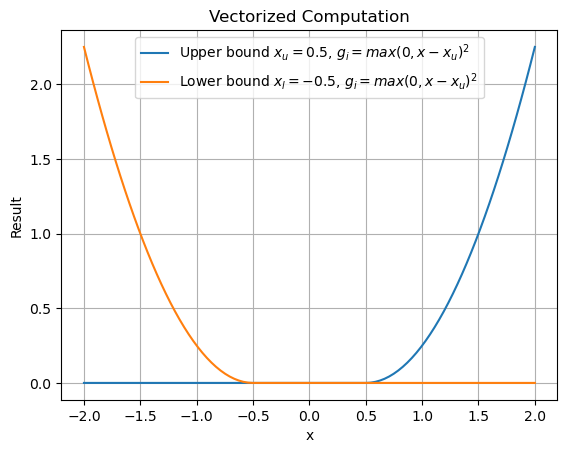

In [167]:
import numpy as np
import matplotlib.pyplot as plt  # Optional for visualization

# Define our global X domain
xspan = np.linspace(-2, 2, 100)

# Define our local domain we want to focus on:
x_u = 0.5
x_l = -0.5

# Define parameters for our penalty functions
p_1 = 1
p_2 = 1

# Define the penalty functions:
def g_1(x):
    return p_1 * np.maximum(0, xspan - x_u)**2
def g_2(x):
    return p_2 * np.maximum(0, -(xspan - x_l))**2


# Plot to visualize
plt.plot(xspan, g_1(xspan), label=f'Upper bound $x_u ={x_u}$, $g_i = max(0, x - x_u)^2$')
plt.plot(xspan, g_2(xspan), label=f'Lower bound $x_l ={x_l}$, $g_i = max(0, x - x_u)^2$')
plt.xlabel('x')
plt.ylabel('Result')
plt.title('Vectorized Computation')
plt.legend()
plt.grid(True)
plt.show()

Note that the function is above is zero for our region of interest $x \in [x_l, x_u]$ so that the final solution is unaffected by the barriers. Feel free to play with the the parameters $p_1$, $p_2$ to get a feeling for how much this affects the gradient of the barriers.

2. Now implement your own custom penalty functions as constraints so that you can redefine the objective function and obtain a new function that is globally convex. Use the the $x_l, x_u$ pair that you found in the first part of the question to define your barrier penalties.


|

### (Optional) Exercise 9: Gradient-Descent Exploration

Experiment with GD on multimodal functions.

1. Use the definition Lipschitz continuity and explain why it affects step size in GD.
2. Identify local vs. global minima in the 2D example from the lecture notes (you can also use the code below) within the domain $[0, 1] \times [0, 1] \in\mathcal{X} $ by using different starting values and then printing the solution given by the optimizer.
3. In the code below we added momentum (modify update to $\mathbf{v}_{k+1} = \beta \mathbf{v}_k - \alpha \nabla f$, $\mathbf{x}_{k+1} = \mathbf{x}_k + \mathbf{v}_{k+1}$ ($\beta=0.9$)) to the python multimodal demonstrations from the lecture notes. Try different starts ($\alpha = 0.01$) and note basins. Try to add your own objective function with shallower basins of attraction.



In [56]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider


# Extend chapter's gd_demo or multimodal widget
def gd_with_momentum(start_x1, start_x2, alpha=0.01, beta=0.9, max_iters=100):
    x = np.array([start_x1, start_x2])
    v = np.zeros(2)
    path = [x.copy()]
    for _ in range(max_iters):
        grad = grad_f(*x)  # From chapter
        v = beta * v - alpha * grad
        x += v
        path.append(x.copy())
    return np.array(path)


min_x = 0
min_y = 0

# Define the multimodal function and gradient
def f(x1, x2):
    return np.sin(3 * np.pi * x1) + np.sin(3 * np.pi * x2) + 0.1 * (x1**2 + x2**2)

def grad_f(x1, x2):
    df_dx1 = 3 * np.pi * np.cos(3 * np.pi * x1) + 0.2 * x1
    df_dx2 = 3 * np.pi * np.cos(3 * np.pi * x2) + 0.2 * x2
    return np.array([df_dx1, df_dx2])

# GD function
def run_gd(start_x1, start_x2, alpha, max_iters=100):
    x = np.array([start_x1, start_x2])
    path = [x.copy()]
    for _ in range(max_iters):
        grad = grad_f(*x)
        x -= alpha * grad
        path.append(x.copy())
        if np.linalg.norm(grad) < 1e-4:
            break
    return np.array(path)

# Interactive plot
def plot_gd(start_x1=0.5, start_x2=0.5, alpha=0.01):
    #path = run_gd(start_x1, start_x2, alpha)
    path = gd_with_momentum(start_x1, start_x2, alpha)
    # Contour plot
    x1 = np.linspace(min_x, 1.5, 200)
    x2 = np.linspace(min_y, 1.5, 200)
    X1, X2 = np.meshgrid(x1, x2)
    Z = f(X1, X2)

    plt.figure(figsize=(8, 6))
    plt.contour(X1, X2, Z, levels=20, cmap='viridis', alpha=0.7)
    plt.colorbar(label='f(x1, x2)')
    plt.plot(path[:, 0], path[:, 1], 'r-', marker='o', markersize=3, label='GD Path')
    plt.scatter(path[0, 0], path[0, 1], color='green', s=100, label='Start')
    plt.scatter(path[-1, 0], path[-1, 1], color='black', s=100, label='End')
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.title('Gradient Descent on Multimodal Function')
    plt.legend()
    plt.grid(True)
    plt.show()

interact(plot_gd,
         start_x1=FloatSlider(min=min_x, max=1.5, step=0.05, value=0.7, description='Start x1:'),
         start_x2=FloatSlider(min=min_y, max=1.5, step=0.05, value=0.6, description='Start x2:'),
         alpha=FloatSlider(min=0.001, max=0.05, step=0.001, value=0.01, description='Alpha:'));



# Integrate into plot_gd function

interactive(children=(FloatSlider(value=0.7, description='Start x1:', max=1.5, step=0.05), FloatSlider(value=0…

Discussion: How do starting points affect convergence in nonconvex space trajectory optimization?

# Part 2: Nonlinear Programming (NLP)

## Excercise 1: KKT Conditions Verification

Verify KKT conditions symbolically and graphically for a simple constrained NLP. Consider the NLP: Minimize $f(x, y) = (x - 1)^2 + (y - 1)^2$ subject to $g(x, y) = x^2 + y^2 - 0.5 \leq 0$.

1. Use SymPy to compute the KKT system (primal/dual feasibility, stationarity, complementarity). Solve for the KKT point and multipliers.
2. Modify the Matplotlib code from the chapter to plot the objective contours, feasible region, and gradients at the KKT point. Verify stationarity visually.
3. Discuss why this satisfies the conditions and its relevance (e.g., optimizing satellite sensor placement under power constraints).


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize, least_squares
import sympy as sp
# Part a: SymPy
x, y, lam = sp.symbols('x y lambda')
f = (x - 1)**2 + (y - 1)**2
g = x**2 + y**2 - 0.5
# ... (complete as in chapter)

# Part b: Plot (adapt chapter code)

## Exercise 2: Trust-Region Methods on Rosenbrock
Implement and analyze a basic trust-region algorithm. Use the Rosenbrock function $f(x, y) = 100(y - x^2)^2 + (1 - x)^2$.

1. Modify the chapter's NumPy trust-region code to track trust radius $\delta_k$ over iterations. Run from initial point $(-1.2, 1)$.
2. Plot the iteration path on contours and the radius evolution. Experiment with different $\eta_0, \eta_1$ (e.g., tighter thresholds) and discuss convergence (e.g., how it handles the "banana" valley, analogous to non-linear trajectory optimization).


In [3]:
# Adapt chapter's rosenbrock and trust_region_opt functions
# Add delta tracking: deltas = [delta0]
# In loop: deltas.append(delta_k)
# Plot: plt.plot(deltas)

## Exercise 3: SQP for Constrained Optimization

Apply SQP to an engineering-inspired problem. Model a simplified thrust allocation: Minimize $f(\mathbf{u}) = \mathbf{u}^\top \mathbf{u}$ (energy) for thrusts $\mathbf{u} = [u_1, u_2]$, subject to $\mathbf{A} \mathbf{u} = \mathbf{\tau}$ (force balance, equality) and $u_1^2 + u_2^2 \leq 1$ (non-linear limit), with $\mathbf{A} = [[1,1],[1,-1]]$, $\mathbf{\tau} = [1, 0.5]$, bounds $|u_i| \leq 0.8$.

1. Use scipy.optimize.minimize(method='SLSQP') to solve. Provide Jacobians if possible for efficiency.
2. Plot the feasible region, constraints, and solution. Discuss active constraints and KKT relevance (e.g., in spacecraft attitude control).

Stub Code:

In [ ]:
# Adapt chapter's objective, constraints
res = minimize(objective, u0, method='SLSQP', bounds=bounds, constraints=constraints)
# Plot: Use plt.fill for circle constraint, lines for equalities

## (Optional) Exercise 3b: Solving NLPs with scipy.optimize.minimize

Extra practice with NLPs using SciPy. Implement and solve NLPs using SciPy, covering bounds, inequality/equality constraints, and parameter tuning. This explores full solver inputs on a toy problem mimicking resource allocation (e.g., optimizing spacecraft power distribution).

1. Define an NLP: Minimize $f(x) = (x_1 - 1)^2 + \sin^2(x_2)$ subject to equality $x_1 + x_2 = 1$, inequality $x_1^2 + x_2^2 \leq 5$, and bounds $x_1, x_2 \geq 0$. Use minimize(method='SLSQP') to solve from initial point $\mathbf{x} = [0.5, 0.5]$.
2. Modify key parameters: Change method to 'trust-constr', add Jacobians (compute symbolically with SymPy if needed), experiment with tolerance (tol=1e-8), and max iterations (maxiter=200). Plot the solution on contours and discuss changes (e.g., convergence speed).
3. Discuss how constraints affect the minimum vs. unconstrained case.

Starter code (contains solution to 1):

## Exercise 4: Non-Linear Least-Squares Fitting

In this exercise we fit a non-linear model to noisy data. Simulate orbital decay data: $r(t) = r_0 e^{-\beta t} + \epsilon$, with noisy measurements (e.g., satellite altitude over time).

1. Generate synthetic data ($r_0=1000, \beta=0.01$) and use scipy.optimize.least_squares to fit parameters.
2. Plot data, true model, and fit. Add bounds (e.g., $\beta > 0$) and discuss Jacobian usage. Relate to estimating drag coefficients from telemetry.
3. Compare to linear least-squares from Chapter 7.

Fitted parameters [r0, beta]: [1.00135245e+03 1.00766039e-02]
Residual sum of squares: 503.9667192609008


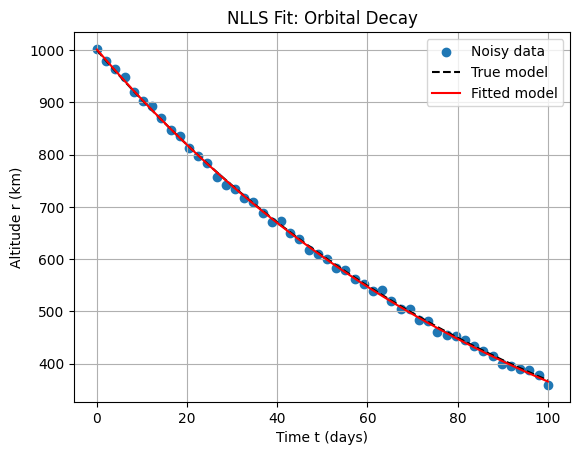

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares

# Data generation: Simulate orbital decay data r(t) = r0 * exp(-beta * t) + epsilon
# True parameters: r0 = 1000 km (initial altitude), beta = 0.01 (decay rate)
np.random.seed(42)  # For reproducibility
t = np.linspace(0, 100, 50)  # Time points (e.g., days)
r0_true = 1000
beta_true = 0.01
epsilon = 5 * np.random.randn(len(t))  # Noise (e.g., measurement error in km)
r_noisy = r0_true * np.exp(-beta_true * t) + epsilon

# Residual function for NLLS
def residuals(params, t, r):
    r0, beta = params
    return #TODO: complete this line

# Initial guess
params0 = [900, 0.005]

# Solve NLLS with bounds (r0 > 0, beta > 0)
bounds = ([0, 0], [np.inf, np.inf])
res = least_squares(residuals, params0, args=(t, r_noisy), bounds=bounds, method='trf')  # Trust-region reflective

print("Fitted parameters [r0, beta]:", res.x)
print("Residual sum of squares:", res.cost)

# Plot
r_fit = res.x[0] * np.exp(-res.x[1] * t)
plt.scatter(t, r_noisy, label='Noisy data')
plt.plot(t, r0_true * np.exp(-beta_true * t), 'k--', label='True model')
plt.plot(t, r_fit, 'r-', label='Fitted model')
plt.xlabel('Time t (days)')
plt.ylabel('Altitude r (km)')
plt.title('NLLS Fit: Orbital Decay')
plt.legend()
plt.grid(True)
plt.show()

## Exercise 5: SGD with Momentum on Noisy 1D Function

Compare SGD (with/without momentum) to a deterministic solver on a noisy loss landscape mimicking NN training.
Define a 1D noisy function $f(x) = (x-2)^2 + 0.5 \sin(10x) + \epsilon$ (big valley with local minima, noise $\epsilon \sim \mathcal{N}(0,0.1)$).

1. [Practice only; solution below] Implement SGD with optional momentum. Use ipywidgets for sliders: learning rate (0.01–0.1), momentum $\beta$ (0–0.99), epochs (100–1000). Plot path and evaluations.
2. Compare to minimize (e.g., 'BFGS' for deterministic). Count evaluations (via callback) and discuss how momentum speeds convergence by escaping local minima.


In [65]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider, IntSlider
from scipy.optimize import minimize

# Noisy function and gradient
def noisy_func(x, sigma=0.1):
    return (x - 2)**2 + 0.5 * np.sin(10 * x) + sigma * np.random.randn()

def grad_noisy(x, sigma=0.1):
    return 2*(x - 2) + 5 * np.cos(10 * x) + sigma * np.random.randn()

# SGD with momentum
def sgd_1d(x0, lr=0.01, beta=0.0, epochs=100, sigma=0.1, tol=1e-3):
    x = x0
    v = 0
    path = [x]
    evals = 0
    x_prev = np.inf
    for _ in range(epochs):
        g = grad_noisy(x, sigma)
        v = beta * v + (1 - beta) * g
        x -= lr * v
        path.append(x)
        evals += 1  # Each grad call is an eval
        #print(f'abs(x - x_prev) = {abs(x - x_prev) }')
        if abs(x - x_prev) < tol:
            break
        else:
            x_prev = x

    return np.array(path), evals

# Deterministic function (noise-free)
def det_func(x):
    return (x - 2)**2 + 0.5 * np.sin(10 * x)

def det_grad(x):
    return 2*(x - 2) + 5 * np.cos(10 * x)

# Deterministic solver (BFGS, without or without noise) with path
def det_solver(x0, noisy=True, jac=True):
    path = [np.array([x0])]
    eval_count = 0
    def callback(xk):
        path.append(xk.copy())
        nonlocal eval_count
        eval_count += 1

    if noisy:
        if jac:
            jac_func = grad_noisy
        else:
            jac_func = None

        res = minimize(noisy_func, np.array([x0]), jac=grad_noisy, method='BFGS', callback=callback)
    else:
        res = minimize(det_func, np.array([x0]), jac=det_grad, method='BFGS', callback=callback)

    print(f'BFGS results: {res}')
    eval_count = res.nfev
    return res.x[0], np.array(path)[:, 0], eval_count

# Interactive plot with subplots
def interactive_sgd(x0=-1.0, lr=0.05, beta=0.9, max_epochs=500, sigma=0.1):
    path_sgd, evals_sgd = sgd_1d(x0, lr, beta, max_epochs, sigma)
    x_opt_det, path_det, evals_det = det_solver(x0)

    x_vals = np.linspace(-1, 4, 200)
    y_vals = det_func(x_vals)  # Noise-free for plot
    y_noisy_overlay = det_func(x_vals) + sigma * np.random.randn(len(x_vals))  # Noisy overlay, no fixed seed

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # SGD subplot
    axs[0].plot(x_vals, y_noisy_overlay, color='gray', alpha=0.7, label='Noisy overlay')
    axs[0].plot(x_vals, y_vals, 'k-', alpha=0.3, label='Noise-free f(x)')
    axs[0].plot(path_sgd, noisy_func(path_sgd, sigma=0), 'tab:red', marker='o', label='SGD Path', markersize=4)
    axs[0].plot(path_sgd[-1], noisy_func(path_sgd[-1], sigma=0), 'x', color='tab:red',label=f'Final SGD: $f({path_sgd[-1]:.2f}) = {det_func(path_sgd[-1]):.2f}$ ', markersize=10)
    axs[0].set_title(f'SGD ({evals_sgd} evals)')
    axs[0].set_xlabel('x')
    axs[0].set_ylabel('f(x)')
    axs[0].legend()
    axs[0].grid(True)

    # BFGS subplot
    axs[1].plot(x_vals, y_noisy_overlay, color='gray', alpha=0.7, label='Noisy overlay')
    axs[1].plot(x_vals, y_vals, 'k-', alpha=0.3, label='Noise-free f(x)')
    axs[1].plot(path_det, det_func(path_det), 'tab:blue', marker='o', label='BFGS Path', markersize=4)
    axs[1].plot(x_opt_det, det_func(x_opt_det), 'x', color='tab:blue',label=f'Final BFGS: $f({x_opt_det:.2f})  = {det_func(x_opt_det):.2f}$ ', markersize=10)
    axs[1].set_title(f'BFGS ({evals_det} evals)')
    axs[1].set_xlabel('x')
    axs[1].legend()
    axs[1].grid(True)

    plt.suptitle('SGD vs. BFGS on Noisy/Non-Linear Function')
    plt.show()

interact(interactive_sgd, x0=FloatSlider(min=-2.0, max=2.0, step=0.1, value=-1.0),
         lr=FloatSlider(min=0.01, max=0.1, step=0.01, value=0.05),
         beta=FloatSlider(min=0.0, max=0.99, step=0.05, value=0.9),
         max_epochs=IntSlider(min=100, max=1000, step=100, value=500),
         sigma=FloatSlider(min=0.0, max=0.5, step=0.05, value=0.1))

interactive(children=(FloatSlider(value=-1.0, description='x0', max=2.0, min=-2.0), FloatSlider(value=0.05, de…

<function __main__.interactive_sgd(x0=-1.0, lr=0.05, beta=0.9, max_epochs=500, sigma=0.1)>

## (Optional) Exercise 5: Integrating Backprop and SGD in NNs

In this exercise train a NN with SGD and momentum on a dataset. Use the non-linear function fitting from Section 8.7.4.
1. Modify the NumPy backprop code to use mini-batch SGD with momentum ($\beta=0.9$). Split data into batches of 32.
2. Plot loss curves with/without momentum. Integrate scikit-learn's MLPRegressor (with 'sgd' solver) for comparison.
3. Discuss why momentum helps (e.g., in training NNs for control policies).

In [5]:
# Adapt forward/backprop from chapter
# For SGD: Randomly sample batches in loop
# Add velocity v = [np.zeros_like(p) for p in theta]
# Update: v[i] = beta * v[i] + (1 - beta) * grads[i]; theta[i] -= lr * v[i]

# scikit-learn: from sklearn.neural_network import MLPRegressor
mlp = MLPRegressor(hidden_layer_sizes=(10,5), solver='sgd', momentum=0.9)
mlp.fit(x, y.ravel())

NameError: name 'MLPRegressor' is not defined